In [1]:
import networkx as nx
import pandas as pd
import numpy as np
import os
import random

import stellargraph as sg
from stellargraph.data import EdgeSplitter
from stellargraph.mapper import GraphSAGELinkGenerator
from stellargraph.layer import GraphSAGE, link_classification
from stellargraph.data import UniformRandomWalk
from stellargraph.data import UnsupervisedSampler
from sklearn.model_selection import train_test_split

from tensorflow import keras
from sklearn import preprocessing, feature_extraction, model_selection
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.metrics import accuracy_score

from stellargraph import globalvar

from stellargraph import datasets
from IPython.display import display, HTML

### Loading the CORA network data

In [2]:
dataset = datasets.Cora()
display(HTML(dataset.description))
G, node_subjects = dataset.load()

In [3]:
print(G.info())

StellarGraph: Undirected multigraph
 Nodes: 2708, Edges: 5429

 Node types:
  paper: [2708]
    Features: float32 vector, length 1433
    Edge types: paper-cites->paper

 Edge types:
    paper-cites->paper: [5429]
        Weights: all 1 (default)
        Features: none


### Specify the other optional parameter values: root nodes, the number of walks to take per node, the length of each walk, and random seed.

In [4]:
nodes = list(G.nodes())
number_of_walks = 1
length = 5

### Create the UnsupervisedSampler instance with the relevant parameters passed to it.

In [5]:
unsupervised_samples = UnsupervisedSampler(
    G, nodes=nodes, length=length, number_of_walks=number_of_walks
)

### Create a node pair generator:

In [6]:
batch_size = 50
epochs = 4
num_samples = [10, 5]

In [7]:
generator = GraphSAGELinkGenerator(G, batch_size, num_samples)
train_gen = generator.flow(unsupervised_samples)

In [8]:
layer_sizes = [50, 50]
graphsage = GraphSAGE(
    layer_sizes=layer_sizes, generator=generator, bias=True, dropout=0.0, normalize="l2"
)

In [9]:
# Build the model and expose input and output sockets of graphsage, for node pair inputs:
x_inp, x_out = graphsage.in_out_tensors()

C:\Users\HP 15\.conda\envs\tf\lib\site-packages\keras\initializers\initializers_v2.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


In [10]:
prediction = link_classification(
    output_dim=1, output_act="sigmoid", edge_embedding_method="ip"
)(x_out)

link_classification: using 'ip' method to combine node embeddings into edge embeddings


In [11]:
model = keras.Model(inputs=x_inp, outputs=prediction)

model.compile(
    optimizer=keras.optimizers.Adam(lr=1e-3),
    loss=keras.losses.binary_crossentropy,
    metrics=[keras.metrics.binary_accuracy],
)

C:\Users\HP 15\.conda\envs\tf\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


### Train the model:

In [12]:
history = model.fit(
    train_gen,
    epochs=epochs,
    verbose=1,
    use_multiprocessing=False,
    workers=4,
    shuffle=True,
)

Epoch 1/4
434/434 [==============================] - 42s 91ms/step - loss: 0.5621 - binary_accuracy: 0.7429
Epoch 2/4
434/434 [==============================] - 40s 92ms/step - loss: 0.5420 - binary_accuracy: 0.7660
Epoch 3/4
434/434 [==============================] - 41s 94ms/step - loss: 0.5379 - binary_accuracy: 0.7798
Epoch 4/4
434/434 [==============================] - 41s 94ms/step - loss: 0.5359 - binary_accuracy: 0.7854


### Extracting node embeddings

In [13]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from stellargraph.mapper import GraphSAGENodeGenerator
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

### Building a new node-based model

In [14]:
x_inp_src = x_inp[0::2]
x_out_src = x_out[0]
embedding_model = keras.Model(inputs=x_inp_src, outputs=x_out_src)

In [15]:
node_ids = node_subjects.index
node_gen = GraphSAGENodeGenerator(G, batch_size, num_samples).flow(node_ids)

In [16]:
node_embeddings = embedding_model.predict(node_gen, workers=4, verbose=1)


55/55 [==============================] - 3s 41ms/step


### Visualize the node embeddings

In [17]:
node_subject = node_subjects.astype("category").cat.codes

X = node_embeddings
if X.shape[1] > 2:
    transform = TSNE  # PCA

    trans = transform(n_components=2)
    emb_transformed = pd.DataFrame(trans.fit_transform(X), index=node_ids)
    emb_transformed["label"] = node_subject
else:
    emb_transformed = pd.DataFrame(X, index=node_ids)
    emb_transformed = emb_transformed.rename(columns={"0": 0, "1": 1})
    emb_transformed["label"] = node_subject

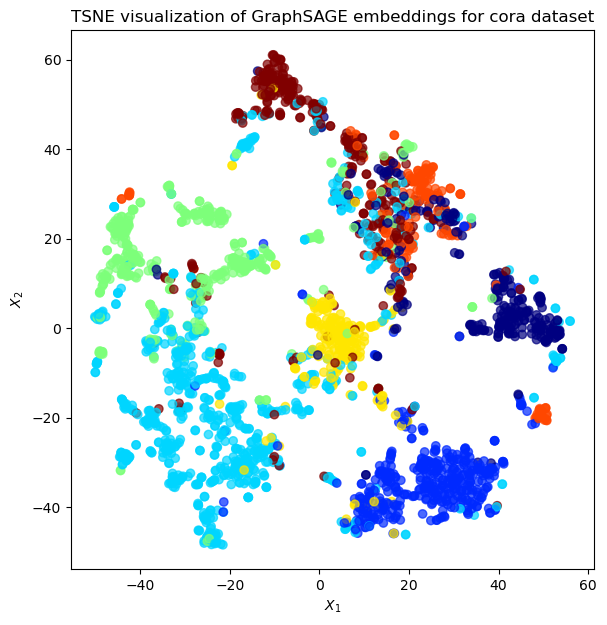

In [18]:
alpha = 0.7

fig, ax = plt.subplots(figsize=(7, 7))
ax.scatter(
    emb_transformed[0],
    emb_transformed[1],
    c=emb_transformed["label"].astype("category"),
    cmap="jet",
    alpha=alpha,
)
ax.set(aspect="equal", xlabel="$X_1$", ylabel="$X_2$")
plt.title(
    "{} visualization of GraphSAGE embeddings for cora dataset".format(transform.__name__)
)
plt.show()

### Downstream task

In [19]:
# X will hold the 50 input features (node embeddings)
X = node_embeddings
# y holds the corresponding target values
y = np.array(node_subject)

### Data Splitting

In [20]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=0.05, test_size=None, stratify=y
)

### Classifier Training

In [21]:
clf = LogisticRegression(verbose=0, solver="lbfgs", multi_class="auto")
clf.fit(X_train, y_train)

LogisticRegression()

In [22]:
y_pred = clf.predict(X_test)

In [23]:
accuracy_score(y_test, y_pred)

0.7730275942479595

### Predicted classes

In [24]:
pd.Series(y_pred).value_counts()

2    713
1    437
3    402
6    290
0    280
5    257
4    194
dtype: int64

### True classes

In [25]:
pd.Series(y).value_counts()

2    818
3    426
1    418
6    351
0    298
4    217
5    180
dtype: int64